In [1]:
import sys,os

import torch
import numpy as np

sys.path.append('..')

from modeling import SRNsModel
import util

_RENDERER = 'FC'
_ORTHO = False

from scipy.stats import norm
from sklearn import manifold

_MODEL_PATH = '/home/anpei/liury/log/SRNs/072515face_seg_real/checkpoints/epoch_0073_iter_080000.pth'
_OPT_CAM = False
_ORTHO = True
_TOT_NUM_INSTANCES = 1689

_IMG_SIZE = 128
_OUT_SIZE = 512

torch.cuda.set_device(0)

model = SRNsModel(num_instances=_TOT_NUM_INSTANCES,
                  latent_dim=256,
                  renderer=_RENDERER,
                  tracing_steps=10,
                  freeze_networks=True,
                  out_channels=20,
                  img_sidelength=_IMG_SIZE,
                  output_sidelength=_OUT_SIZE,
                  opt_cam=_OPT_CAM,
                  orthogonal=_ORTHO)

util.custom_load(model, path=_MODEL_PATH, discriminator=None,
                 overwrite_embeddings=False, overwrite_cam=True)

model.eval()
model.cuda()

[INIT embedding] variable.
[INIT renderer] FC, with renderer = FC


RuntimeError: Error(s) in loading state_dict for SRNsModel:
	Unexpected key(s) in state_dict: "hyper_phi.layers.3.hyper_linear.hypo_params.net.0.net.0.weight", "hyper_phi.layers.3.hyper_linear.hypo_params.net.0.net.0.bias", "hyper_phi.layers.3.hyper_linear.hypo_params.net.0.net.1.weight", "hyper_phi.layers.3.hyper_linear.hypo_params.net.0.net.1.bias", "hyper_phi.layers.3.hyper_linear.hypo_params.net.1.net.0.weight", "hyper_phi.layers.3.hyper_linear.hypo_params.net.1.net.0.bias", "hyper_phi.layers.3.hyper_linear.hypo_params.net.1.net.1.weight", "hyper_phi.layers.3.hyper_linear.hypo_params.net.1.net.1.bias", "hyper_phi.layers.3.hyper_linear.hypo_params.net.2.weight", "hyper_phi.layers.3.hyper_linear.hypo_params.net.2.bias", "ray_marcher.out_layer.weight", "ray_marcher.out_layer.bias", "ray_marcher.lstm.weight_ih", "ray_marcher.lstm.weight_hh", "ray_marcher.lstm.bias_ih", "ray_marcher.lstm.bias_hh", "pixel_generator.net.4.net.0.weight", "pixel_generator.net.4.net.0.bias", "pixel_generator.net.4.net.1.weight", "pixel_generator.net.4.net.1.bias", "pixel_generator.net.5.weight", "pixel_generator.net.5.bias", "pixel_generator.net.3.net.0.weight", "pixel_generator.net.3.net.0.bias", "pixel_generator.net.3.net.1.weight", "pixel_generator.net.3.net.1.bias". 

In [2]:
%matplotlib inline

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


_CMAP = np.asarray([[0, 0, 0], [127, 212, 255], [255, 255, 127], [255, 255, 127], # 'background','skin', 'l_brow', 'r_brow'
                    [255, 255, 170], [255, 255, 170], [240, 157, 240], [255, 212, 255], #'l_eye', 'r_eye', 'r_nose', 'l_nose',
                    [31, 162, 230], [127, 255, 255], [127, 255, 255], #'mouth', 'u_lip', 'l_lip'
                    [0, 255, 85], [0, 255, 85], [0, 255, 170], [255, 255, 170], #'l_ear', 'r_ear', 'ear_r', 'eye_g'
                    [127, 170, 255], [85, 0, 255], [255, 170, 127], #'neck', 'neck_l', 'cloth'
                    [212, 127, 255], [0, 170, 255]#, 'hair', 'hat'
                    ])

_CMAP =torch.tensor(_CMAP, dtype=torch.float32) / 255.0


def _campos2matrix(cam_pos, cam_center=None, cam_up=None):
    _cam_target = np.asarray([0,0.11,0.1]) if cam_center is None else cam_center
    _cam_target = _cam_target.reshape((1, 3))
    # print('*** cam_center = ', _cam_target.shape)

    _cam_up = np.asarray([0.0, 1.0, 0.0]) if cam_up is None else cam_up

    cam_dir = (_cam_target-cam_pos)
    cam_dir = cam_dir / np.linalg.norm(cam_dir)
    cam_right = np.cross(cam_dir, _cam_up)
    cam_right = cam_right / np.linalg.norm(cam_right)
    cam_up = np.cross(cam_right, cam_dir)

    cam_R = np.concatenate([cam_right.T, cam_up.T, cam_dir.T], axis=1)

    cam_P = np.eye(4)
    cam_P[:3, :3] = cam_R
    cam_P[:3, 3] = cam_pos

    return cam_P


_CAM_INT = np.load(
    '/home/anpei/liury/data/facial-data/seg_face_real/intrinsics_avg.npy')

_CAM_INT[0, 0] *= (_IMG_SIZE / 512.0)
_CAM_INT[1, 1] *= (_IMG_SIZE / 512.0)
_CAM_INT[0, 2] *= (_IMG_SIZE / 512.0)
_CAM_INT[1, 2] *= (_IMG_SIZE / 512.0)

_CAM_INT = torch.from_numpy(_CAM_INT).float().unsqueeze(0)

lookat = np.asarray([-1.5, -1.5, 0.0])
cam_center =  np.asarray([-1.5, -1.5, 1.5])
cam_up = np.asarray([0.0, 1.0, 0.0])

_CAM_POSE = _campos2matrix(cam_center, lookat, cam_up)
_CAM_POSE = torch.from_numpy(_CAM_POSE).float().unsqueeze(0)

_UV = np.mgrid[0:_IMG_SIZE, 0:_IMG_SIZE].astype(np.int32)
_UV = torch.from_numpy(np.flip(_UV, axis=0).copy()).long()
_UV = _UV.reshape(2, -1).transpose(1, 0).unsqueeze(0)


def render_latent(model, z):
    B, L = z.shape
    
    with torch.no_grad():
        pose = _CAM_POSE.expand(B, -1, -1)
        cam_int = _CAM_INT.expand(B, -1, -1)
        uv = _UV.expand(B, -1, -1)

        predictions, depth_maps = model(pose, z, cam_int, uv) # (B, L*L, C)

        pred = torch.argmax(predictions, dim=2, keepdim=True)

        out_img = util.lin2img(pred, color_map=_CMAP) # (B, C, L, L)
        out_seg = pred.view(B, _OUT_SIZE, _OUT_SIZE, 1).cpu().numpy()

        print(out_img.shape)
        
        out_img = make_grid(out_img*255, range=(0, 255), nrow=4, padding=10, normalize=True)
        
        out_seg = out_seg.squeeze().astype(np.uint8) # (B, L, L)

        return out_img, out_seg



In [3]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def fit_gmm(gmm, model):
    
    X = model.latent_codes.weight.data.cpu().numpy()
    gmm.fit(X)
    sample_latents = gmm.sample(8)
    
    print("*** sample_latents = ", sample_latents)

In [46]:
from scipy.stats import norm
from sklearn import manifold
from sklearn import mixture

_NUM_COMP = 16

gmm = mixture.GaussianMixture(n_components=_NUM_COMP, covariance_type='full', random_state=0)
X = model.latent_codes.weight.data.cpu().numpy()
gmm.fit(X)

sample_z = gmm.sample(1)[0]
sample_z = torch.from_numpy(gmm.sample(1)[0])

In [51]:
out_img, out_seg = render_latent(model, sample_z.float())
print(out_img.shape)

print("*** sample_latents = ", sample_latents.shape)

torch.Size([8, 3, 512, 512])
torch.Size([3, 1054, 2098])
*** sample_latents =  (8, 256)


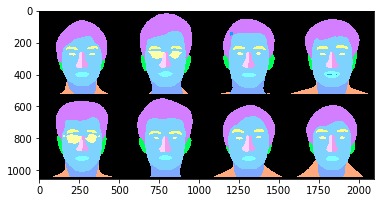

In [53]:
show(out_img)

In [28]:

import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


class VAE(nn.Module):
  
    def __init__(self, in_dim=256, feat_dim=400):
        super(VAE, self).__init__()
        
        self.in_dim = in_dim
        
        self.fc1 = nn.Linear(in_dim, feat_dim)
        self.fc2_mu = nn.Linear(feat_dim, 2)
        self.fc2_sig = nn.Linear(feat_dim, 2)
        self.fc3 = nn.Linear(2, feat_dim)
        self.fc4 = nn.Linear(feat_dim, in_dim)
  
    def encode(self, x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        return a_mu, a_logvar
  
    def decode(self, z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1, self.in_dim))
        z = self.reparameterize(mu, logvar)
        
        return self.decode(z), mu, logvar
    
    
class LatentDataset(Dataset):

    def __init__(self, model, data_len=1000, offset=0):
        self.model = model
        self.data_len = data_len
        self.offset = offset

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        return self.model.get_embedding(
            {'instance_idx': torch.LongTensor([(idx+self.offset)%self.data_len]).squeeze().cuda()})
    
    
def loss_function(recon_x, x, mu, logvar):    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

Epoch : 1 , Minibatch : 0 Loss = 0.27705455 Val Loss = 4.17892319
Epoch 1 : Loss = (4.06338394) 
Epoch : 2 , Minibatch : 0 Loss = 0.25754046 Val Loss = 3.89115897
Epoch 2 : Loss = (3.78110790) 
Epoch : 3 , Minibatch : 0 Loss = 0.23997873 Val Loss = 3.61830616
Epoch 3 : Loss = (3.51460207) 
Epoch : 4 , Minibatch : 0 Loss = 0.22420526 Val Loss = 3.36102918
Epoch 4 : Loss = (3.26353517) 
Epoch : 5 , Minibatch : 0 Loss = 0.20887518 Val Loss = 3.11962029
Epoch 5 : Loss = (3.02812868) 
Epoch : 6 , Minibatch : 0 Loss = 0.18790746 Val Loss = 2.89317873
Epoch 6 : Loss = (2.80743748) 
Epoch : 7 , Minibatch : 0 Loss = 0.18209022 Val Loss = 2.68094242
Epoch 7 : Loss = (2.60067192) 
Epoch : 8 , Minibatch : 0 Loss = 0.16207141 Val Loss = 2.48228276
Epoch 8 : Loss = (2.40715930) 
Epoch : 9 , Minibatch : 0 Loss = 0.15350431 Val Loss = 2.29642770
Epoch 9 : Loss = (2.22628245) 
Epoch : 10 , Minibatch : 0 Loss = 0.14380854 Val Loss = 2.12263829
Epoch 10 : Loss = (2.05707976) 
Epoch : 11 , Minibatch : 0 L

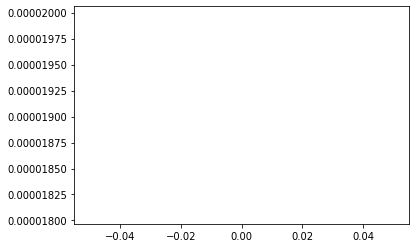

In [30]:
model_vae = VAE()
model_vae = model_vae.cuda()

optimizer = optim.Adam(model_vae.parameters(), lr=1e-4)

train_dataset = LatentDataset(model, 1500, 0)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=100, shuffle=True)


val_dataset = LatentDataset(model, data_len=100, offset=1500)
val_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=100, shuffle=True)


num_epochs = 500
print_per = 100

model.train()
for epoch in range(num_epochs):
    
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, x in enumerate(train_loader):
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model_vae(x)
        
        loss = loss_function(recon_batch, x, mu, logvar)
        
        loss.backward()
        
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        
        if (i%print_per == 0):            
            # validation
            model_vae.eval()
            with torch.no_grad():
                
                val_loss = 0.
                for _, val_x in enumerate(val_loader):
                    recon_val_x, mu, logvar = model_vae(val_x)
                    
                    print(recon_val_x.shape)
                    
                    val_loss += loss_function(recon_val_x, val_x, mu, logvar).item()
                    
            model_vae.train()
            
            print("Epoch : {} , Minibatch : {} Loss = {:.8f} Val Loss = {:.8f}".format(epoch+1, i, print_loss, val_loss))
            loss_record.append(print_loss)
            print_loss = 0
            
    print("Epoch {} : Loss = ({:.8f}) ".format(epoch+1, train_loss))
    
    
plt.plot(loss_record)

In [ ]:
_CMAP = np.asarray([[0, 0, 0], [127, 212, 255], [255, 255, 127], [255, 255, 127], # 'background','skin', 'l_brow', 'r_brow'
                    [255, 255, 170], [255, 255, 170], [240, 157, 240], [255, 212, 255], #'l_eye', 'r_eye', 'r_nose', 'l_nose',
                    [31, 162, 230], [127, 255, 255], [127, 255, 255], #'mouth', 'u_lip', 'l_lip'
                    [0, 255, 85], [0, 255, 85], [0, 255, 170], [255, 255, 170], #'l_ear', 'r_ear', 'ear_r', 'eye_g'
                    [127, 170, 255], [85, 0, 255], [255, 170, 127], #'neck', 'neck_l', 'cloth'
                    [212, 127, 255], [0, 170, 255]#, 'hair', 'hat'
                    ])

_CMAP =torch.tensor(_CMAP, dtype=torch.float32) / 255.0


def _campos2matrix(cam_pos, cam_center=None, cam_up=None):
    _cam_target = np.asarray([0,0.11,0.1]) if cam_center is None else cam_center
    _cam_target = _cam_target.reshape((1, 3))
    # print('*** cam_center = ', _cam_target.shape)

    _cam_up = np.asarray([0.0, 1.0, 0.0]) if cam_up is None else cam_up

    cam_dir = (_cam_target-cam_pos)
    cam_dir = cam_dir / np.linalg.norm(cam_dir)
    cam_right = np.cross(cam_dir, _cam_up)
    cam_right = cam_right / np.linalg.norm(cam_right)
    cam_up = np.cross(cam_right, cam_dir)

    cam_R = np.concatenate([cam_right.T, cam_up.T, cam_dir.T], axis=1)

    cam_P = np.eye(4)
    cam_P[:3, :3] = cam_R
    cam_P[:3, 3] = cam_pos

    return cam_P


_CAM_INT = np.load(
    '/home/anpei/liury/data/facial-data/seg_face_real/intrinsics_avg.npy')

_CAM_INT[0, 0] *= (_IMG_SIZE / 512.0)
_CAM_INT[1, 1] *= (_IMG_SIZE / 512.0)
_CAM_INT[0, 2] *= (_IMG_SIZE / 512.0)
_CAM_INT[1, 2] *= (_IMG_SIZE / 512.0)

_CAM_INT = torch.from_numpy(_CAM_INT).float().unsqueeze(0)

lookat = np.asarray([-1.5, -1.5, 0.0])
cam_center =  np.asarray([-1.5, -1.5, 1.5])
cam_up = np.asarray([0.0, 1.0, 0.0])

_CAM_POSE = _campos2matrix(cam_center, lookat, cam_up)
_CAM_POSE = torch.from_numpy(_CAM_POSE).float().unsqueeze(0)

_UV = np.mgrid[0:_IMG_SIZE, 0:_IMG_SIZE].astype(np.int32)
_UV = torch.from_numpy(np.flip(_UV, axis=0).copy()).long()
_UV = _UV.reshape(2, -1).transpose(1, 0).unsqueeze(0)


def render_latent(model, z):
    B, L = z.shape
    
    with torch.no_grad():
        pose = _CAM_POSE.expand(B, -1, -1)
        cam_int = _CAM_INT.expand(B, -1, -1)
        uv = _UV.expand(B, -1, -1)

        predictions, depth_maps = model(pose, z, cam_int, uv)

        pred = torch.argmax(predictions, dim=2, keepdim=True)

        out_img = util.lin2img(pred, color_map=_CMAP).cpu().numpy()
        out_seg = pred.view(img_sidelength, img_sidelength, 1).cpu().numpy()

        out_img = (out_img.squeeze().transpose(1, 2, 0)) * 255.0
        out_img = out_img.round().clip(0, 255).astype(np.uint8)

        out_seg = out_seg.squeeze().astype(np.uint8)

        return out_img, out_seg

